### Задачи к Лекции 3

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
# Делаем one-hot кодирование
chol = pd.get_dummies(df["cholesterol"], prefix="chol")
gluc = pd.get_dummies(df["gluc"], prefix="gluc")
df = pd.concat([df, chol, gluc], axis=1)

# Делаем пол бинарным признаком
df["gender_bin"] = df["gender"].map({1: 0, 2: 1})

# Чистим от плохих данных
df = df[(df["age"] > 12500)&
        (df["weight"] > 40)&(df["weight"] < 105)&
        (df["height"] > 140)&(df["height"] < 190)&
        (df["ap_lo"] > 60)&(df["ap_lo"] < 110)&
        (df["ap_hi"] > 80)&(df["ap_hi"] < 170)
     ]
print(df.shape)
df.head()

(61646, 19)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,gender_bin
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,1,0,0,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,1,0,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,0,0,1,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,1,0,0,1
8,21914,1,151,67.0,120,80,2,2,0,0,0,0,0,1,0,0,1,0,0


## Классы в Python

Нередко, возникает необходимость создания объектов с каким-нибудь внутренним поведением и состоянием. Примерами таких объектов являются классификаторы sklearn, массивы numpy и много другое. Такой объект можно объявить с помощью ключевого слова **class**

```python
class SomeObject:
    def __init__(self, depth):
        self.a = depth
        self.target = None
        
    def fit(self, data, target):
        self.target = data
        # magic
        return 
    
    def predict(self, data):
        return self.target    
```

После этого в коде можно будет создать экземпляр данного класса
```python
a = SomeObject(depth=5)
a.fit(data, target)
a.predict(data)
```

## Задачи

**1. В sklearn на данный момент отсутствует функционал для построения деревьев решений из категориальных данных, поэтому его нужно сделать самостоятельно и проверить его работу. Что нужно сделать:**

* __создать классификатор используя только pandas, numpy и scipy. Необходимо его сделать самому, используя исключительно только numpy, pandas и scipy (запрещено использовать sklearn и прочие библиотеки). Напоминаю, что для категориальных данных операция < или > не имеют смысла (использовать только != и ==). Гиперпараметром данного классификатора должна быть максимальная глубина дерева.__
* __Проверить работу данного классификатора на наборе ("gender", "cholesterol", "gluc").__
* __С помощью кросс-валидации найти оптимальную глубину этого дерева. Для вашего классификатора GridSearchCV не подойдет, придется это сделать также самостоятельно.__
* __Нарисовать полученное дерево (я должен понять, как и откуда вы его нарисовали).__

Алгоритм работы классификатора:
 1. Перебираем все возможные признаки и смотрим либо неопределенность Джини, либо прирост информации. Это даст критерий разбиения в виде "признак == значение"
 2. Если выборка полученная при разбиении состоит из объектов одного класса (соответсвует нулевой энтропии), то данный лист просто возвращает значение этого класса.
 3. В противном случае, образуется новый узел и для него начинаем с пункта 1.
 4. Если достигли максимальной глубины, то вместа узла создаем лист, который возвращает самое вероятное значение.

Для начала создадим обучающую и тестовую выборки.

In [10]:
from sklearn.model_selection import train_test_split
data = df[["gender", "cholesterol", "gluc"]].values
#data = df[["gender", "cholesterol", "gluc", "smoke", "alco", "active"]], df['cardio']
target = df['cardio'].values
train, test, target_train, target_test = train_test_split(   
    data, target, 
    test_size=0.3)

In [11]:
class RecursiveTree:
    def __init__(self, max_depth): 
        self.max_depth = max_depth

        # Есть всегда (листьев и узлов)
        self.p0 = None
        self.p1 = None
        self.size = None
        self.target = None
        self.entropy = None
        
        # Есть только у узлов
        self.feature_num = None
        self.feature_value = None
        self.childs = None
        
    def set_depth(self, max_depth):
        self.max_depth = max_depth
        if self.childs is not None:
            self.childs[0].set_depth(max_depth - 1)
            self.childs[1].set_depth(max_depth - 1)
    
    def _entropy(self, values):
        """
            Считаем энтропию для вектора целевых исходов
        """
        p = values.sum() / values.shape[0]
        q = 1.0 - p        
        return - np.nan_to_num(p * np.log2(p)) - np.nan_to_num(q * np.log2(q))
    
    def print(self, names, tab=0):              
        if self.childs is not None:
            print("  "*tab, "[%4s == %2d][%6d]" % (names[self.feature_num], self.feature_value, self.size), 
              "%4.2f %4.2f %2d %7.5f" %(self.p0, self.p1, self.target, self.entropy))
            self.childs[0].print(names, tab+1)
            self.childs[1].print(names, tab+1)
        else:
            print("  "*tab, "[____ == __][%6d]" % self.size, 
              "%4.2f %4.2f %2d %7.5f" %(self.p0, self.p1, self.target, self.entropy))
            
    def _get_dot_code(self, names, name, parent=None):
        """
            names - имена признаков, для расшифровки
            name - имя узла (уникальное)
            parent - имя родительского узла
        """
        content = "\n"

        if self.childs is not None:
            content += '%s [label="%s == %s\\nS = %.3f\\nsamples = %d\\nprob = [%.2f, %.2f]", fillcolor="#%X"];\n' % (
                name, 
                names[self.feature_num], self.feature_value, 
                self.entropy, self.size, 
                self.p0, self.p1,
                (0xe5813900 if self.p0 > self.p1 else 0x399de500) 
                + int(0xff * (self.p0 if self.p0 > self.p1 else self.p1))
            )               
        else:
            content += '%s [label="S = %.3f\\nsamples = %d\\nprob = [%.2f, %.2f]", fillcolor="#%X"];\n' % (
                name, 
                self.entropy, self.size, 
                self.p0, self.p1,
                (0xe5813900 if self.p0 > self.p1 else 0x399de500) 
                + int(0xff * (self.p0 if self.p0 > self.p1 else self.p1))
            )               
            
        if parent is not None:
            content += "%s -> %s;" % (parent, name)
            
        if self.childs is not None:
            content += self.childs[0]._get_dot_code(names, name + "f", name)
            content += self.childs[1]._get_dot_code(names, name + "t", name)
            
        return content
            
    def to_dot(self, filename, names):
        f = open(filename, "w")
        content = self._get_dot_code(names, "root", None)
        f.write("digraph Tree {\n")
        f.write('\tnode [shape=box, style="filled", color="black"];\n')
        f.write(content)
        f.write("}")
        f.close()        
        
    def _predict_proba(self, features):
        if self.childs is None or self.max_depth <= 0:
            return self.p0, self.p1
        
        if features[self.feature_num] == self.feature_value:
            return self.childs[1]._predict_proba(features)
        else:
            return self.childs[0]._predict_proba(features)
        
    def _predict(self, features):
        if self.childs is None or self.max_depth <= 0:
            return self.target
        
        if features[self.feature_num] == self.feature_value:
            return self.childs[1]._predict(features)
        else:
            return self.childs[0]._predict(features)
        
    def predict(self, data):
        data = np.array(data)
        result = np.zeros(data.shape[0])
        for i, features in enumerate(data):
            result[i] = self._predict(features)
        return result
    
    def predict_proba(self, data):
        data = np.array(data)
        result = np.zeros( (data.shape[0], 2) )
        for i, features in enumerate(data):
            result[i] = self._predict_proba(features)
        return result
    
    def fit(self, data, target):
        data = np.array(data)
        target = np.array(target)
        
        # Заполняем данные о текущем дереве
        mask = target == 0
        self.size = target.shape[0]
        self.p0 = mask.sum() / self.size
        self.p1 = 1.0 - self.p0
        self.target = 1 if self.p1 > self.p0 else 0
        self.entropy = self._entropy(target)        
        
        if self.entropy == 0:
            return
                
        # Строим разбиение        
        n_features = data.shape[1]        
        features = [np.unique(data[:,i]) for i in range(n_features)]
        
        split_best = None
        split_feature = None
        split_feature_value = None
        split_mask_true = None
        split_mask_false = None
        
        for i, feature in enumerate(features):
            # Если признак состоит из одного значения, то по нему нельзя сделать разбиение
            if len(feature) < 2:
                continue
                
            for fv in feature:
                mask = data[:, i] == fv
                not_mask = np.logical_not(mask)
                
                S_true = self._entropy(target[mask])
                S_false = self._entropy(target[not_mask])
                
                p_true = mask.sum() / mask.shape[0]
                p_false = 1.0 - p_true
                
                dS = p_true * S_true + p_false * S_false
                
                if split_best is None or split_best > dS:
                    split_best = dS
                    split_feature = i
                    split_feature_value = fv
                    split_mask_true = mask
                    split_mask_false = not_mask

        if split_best is None:
            return
                   
        self.feature_num = split_feature
        self.feature_value = split_feature_value

        self.childs = [RecursiveTree(self.max_depth - 1), RecursiveTree(self.max_depth - 1)]
        self.childs[0].fit(data[split_mask_false], target[split_mask_false])
        self.childs[1].fit(data[split_mask_true], target[split_mask_true])

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

tree = RecursiveTree(4)
tree.fit(train, target_train)
pv = tree.predict_proba(test)
yv = tree.predict(test)

print("Accuracy = ", accuracy_score(target_test, yv))
print("ROC AUC = ", roc_auc_score(target_test, pv[:, 1]))
print("f1_score = ", f1_score(target_test, yv))
#tree.print(names=["gend", "chol", 'gluc', 'smok', 'alco', 'actv'])
tree.to_dot("graph.dot", names=["gend", "chol", 'gluc', 'smok', 'alco', 'actv'])
!dot -Tpng "graph.dot" -o "graph.png"

Accuracy =  0.5969503622796583
ROC AUC =  0.6007327751972497
f1_score =  0.471797052154195


<img src="graph.png"/>

In [13]:
%%time

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

tree = RecursiveTree(0)

# Просто создаю генератор фолдов
kf = KFold(n_splits=3, random_state=13, shuffle=True)
#kf = StratifiedKFold(n_splits=3, random_state=13, shuffle=True)

max_depth = np.arange(1, 18, 1)
acc = np.zeros(max_depth.shape)
roc = np.zeros(max_depth.shape)
f1 = np.zeros(max_depth.shape)

for train_index, test_index in kf.split(data, target):
    data_train, data_test = data[train_index], data[test_index]
    target_train, target_test = target[train_index], target[test_index]
    
    # Благодаря тому, что у меня дерево строится до максимума,
    # а предсказание происходит до указанной глубины, мне достаточно
    # создать модель 1 раз
    tree.fit(data_train, target_train)
    
    for i, d in enumerate(max_depth):
        tree.set_depth(d)
        pv = tree.predict_proba(data_test)[:,1]
        cv = pv >= 0.5
        
        acc[i] += accuracy_score(target_test, cv)
        roc[i] += roc_auc_score(target_test, pv)
        f1[i] += f1_score(target_test, cv)

acc = acc / kf.get_n_splits()
roc = roc / kf.get_n_splits()
f1 = f1 / kf.get_n_splits()

CPU times: user 5.79 s, sys: 48.5 ms, total: 5.84 s
Wall time: 5.96 s


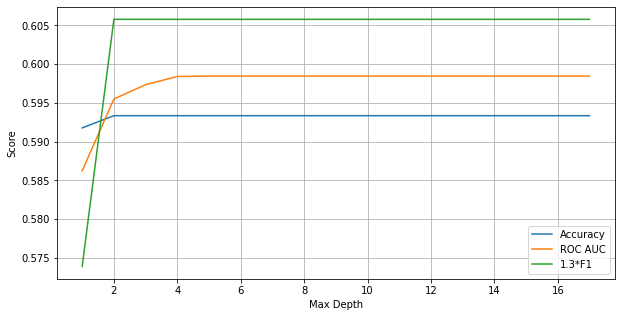

In [14]:
plt.figure(figsize=(10, 5))
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.plot(max_depth, acc, label="Accuracy")
plt.plot(max_depth, roc, label="ROC AUC")
plt.plot(max_depth, 1.3*f1, label="1.3*F1")
plt.legend()
plt.grid()
plt.show()

**2. Выше, данные были приведены либо к бинарным признакам, либо к количественным. Это позволяет воспользоваться классификатором DecisionTreeClassifier. Нужно с помощью кросс-валидации найти оптимальный набор признаков. Показать и объяснить, как данный набор был получен.**

**3. В этой задаче можно использовать sklearn. Для набора признаков полученных в задаче 3, с помощью кросс-валидации найти оптимальный набор гиперпараметров.**

Я объединил решения данных задач в одну

In [102]:
def grey_code(n):
    return n ^ (n >> 1)

def to_idx(n):
    result = []
    idx = 0
    while n:
        if n % 2:
            result.append(idx)
        n = n >> 1
        idx = idx + 1
    return result

def extract(idx, data):
    """
        Формирует список полей на основе индексов, распаковывая вложеные списки
    """
    result = []
    for i in idx:        
        if isinstance(data[i], list) or isinstance(data[i], tuple):
            for f in data[i]:
                result.append(f)
        else:
            result.append(data[i])
    return result

def combinations(max_lenght):
    """
        Возвращает все доступные комбинации индексов с помощью кодов Грея
    """
    n = 1
    result = []
    while True:
        code = grey_code(n)
        idx = to_idx(code)
        if code >= (1 << max_lenght):
            break        
        result.append(idx)
        n += 1
    return result

Я просто беру все признаки, с учетом группировки (то есть холестерин идет сразу тройкой признаков или никак). Далее полным перебором всех комбинаций смотрю значение метрики.

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

features = [
    'age', 'height', 'weight', 'ap_hi', 'ap_lo', 
    'smoke', 'alco', 'active',
    ['chol_1', 'chol_2', 'chol_3'],
    ['gluc_1', 'gluc_2', 'gluc_3'], 
    'gender_bin'
]

params = {
    'max_depth': np.arange(1, 15, 1),
}

tree = DecisionTreeClassifier(random_state=13)
grid = GridSearchCV(
    tree, params, scoring='accuracy',
    cv=2, refit=False,
)

comb = combinations(len(features))

In [ ]:
# Все результаты буду записывать в файл, для дальнейшего анализа
# считать будет очень долго
with open("feature_selection_acc.txt", "w") as f:
    for i, cc in enumerate(comb):
        feature_comb = extract(cc, features)
        a = grid.fit(df[feature_comb], df['cardio'])

        print("=>", "[%d/%d]\t" % (i+1, len(comb)), feature_comb)    

        record = [grid.best_score_, feature_comb, grid.best_params_]        
        print(record, file=f)
        f.flush()

Давайте посмотрим самые лучшие признаки

In [105]:
records = []

## Загружаем их из файла
with open("feature_selection.txt") as f:
    for line in f:
        if len(line.strip()) == 0: continue
        score, features, params = eval(line)
        records.append([score, features, params])

## Сортируем        
records.sort(key=lambda x: x[0], reverse=True)

## Выводим
for score, features, params in records[:10]:
    print("=> ", score, "\n\t", features, "\n\t", params)

=>  0.7163033571225497 
	 ['age', 'height', 'ap_hi', 'active', 'chol_1', 'chol_2', 'chol_3'] 
	 {'max_depth': 4}
=>  0.7163033571225497 
	 ['age', 'ap_hi', 'active', 'chol_1', 'chol_2', 'chol_3'] 
	 {'max_depth': 4}
=>  0.7163033571225497 
	 ['age', 'ap_hi', 'smoke', 'active', 'chol_1', 'chol_2', 'chol_3'] 
	 {'max_depth': 4}
=>  0.7163033571225497 
	 ['age', 'height', 'ap_hi', 'smoke', 'active', 'chol_1', 'chol_2', 'chol_3'] 
	 {'max_depth': 4}
=>  0.7163033571225497 
	 ['age', 'height', 'ap_hi', 'smoke', 'alco', 'active', 'chol_1', 'chol_2', 'chol_3'] 
	 {'max_depth': 4}
=>  0.7163033571225497 
	 ['age', 'ap_hi', 'smoke', 'alco', 'active', 'chol_1', 'chol_2', 'chol_3'] 
	 {'max_depth': 4}
=>  0.7163033571225497 
	 ['age', 'ap_hi', 'alco', 'active', 'chol_1', 'chol_2', 'chol_3'] 
	 {'max_depth': 4}
=>  0.7163033571225497 
	 ['age', 'height', 'ap_hi', 'alco', 'active', 'chol_1', 'chol_2', 'chol_3'] 
	 {'max_depth': 4}
=>  0.7163033571225497 
	 ['age', 'height', 'ap_hi', 'alco', 'chol_1

Если посмотреть на топ лучших наборов, то везде фигурирует признак **age**, **ap_hi**, **chol_X**, далее нередко встречается **height** и некторые катгориальные признаки. Таким образом, возраст, верхнее давление и уровень холестирина являтся самыми основными признаками, остальные дают лишь незначительный вклад в улучшение качества работы классификатора.

Имеется более "оптимальный" подход, мы можем добавлять признаки по одному, выбирая самый лучший при каждом добавлении.

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

features = [
    'age', 'height', 'weight', 'ap_hi', 'ap_lo', 
    'smoke', 'alco', 'active',
    'chol_1', 'chol_2', 'chol_3',
    'gluc_1', 'gluc_2', 'gluc_3', 
    'gender_bin'
]

params = {
    'max_depth': np.arange(1, 15, 1),
}

tree = DecisionTreeClassifier(random_state=13)
grid = GridSearchCV(
    tree, params, scoring='accuracy',
    cv=3, refit=False,
)

# Последнее лучшая подсчитанная метрика
last_score = 0
best_features = []
best_params = None
while True:
    next_feature = None
    for feature in features:
        current_features = best_features + [feature,]
        result = grid.fit(df[current_features].values, df['cardio'].values)
        
        # Сохраням, если результат лучше, чем был
        if last_score < grid.best_score_:
            print("=>", "%s = (%s | %s)\t" % (current_features, grid.best_score_, grid.best_params_))
            next_feature = feature 
            last_score = grid.best_score_
            best_params = grid.best_params_
    
    if next_feature is None:
        break
    i = features.index(next_feature)
    best_features.append(features[i])
    del features[i]

=> ['age'] = (0.5980436686889661 | {'max_depth': 1})	
=> ['ap_hi'] = (0.7071667261460598 | {'max_depth': 1})	
=> ['ap_hi', 'age'] = (0.7151315576030886 | {'max_depth': 4})	
=> ['ap_hi', 'chol_3'] = (0.7193005223372158 | {'max_depth': 2})	
=> ['ap_hi', 'chol_3', 'age'] = (0.7229341725334977 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo'] = (0.7241670181358076 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'smoke'] = (0.7242156830937936 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'gluc_1'] = (0.7245401161470331 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'gluc_3'] = (0.7249132141582585 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'gluc_3', 'smoke'] = (0.7249294358109204 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'gluc_3', 'gluc_1'] = (0.7249456574635824 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'gluc_3', 'gender_bin'] = (0.7251403172955261 | {'max_depth': 7})	
=> ['ap_hi', 'chol_3',

Здесь можно увидеть практически тот же набор значений, за исключением того, что благодаря новым бинарным признакам, удалось добиться чуть большего результата.

**4. Сравнить с помощью кросс-валидации классификатор "наивный байес" и "решающее дерево" на количественных признаках. Показать, какой из них лучше.**

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

data= df[['age','height','weight', 'ap_hi', 'ap_lo']].values
target = df['cardio'].values

classifiers = [("Tree(depth=%d)" % i, DecisionTreeClassifier(max_depth=i, random_state=13)) for i in range(1, 15)]
classifiers.append(("GaussianNB()", GaussianNB()))

results = []
for name, classifier in classifiers:
    cv = cross_validate(classifier, data, target, cv=3, scoring=['accuracy', 'f1', 'roc_auc'])
    results.append((name, cv["test_f1"].mean(), cv["test_accuracy"].mean(), cv["test_roc_auc"].mean()))

dr = pd.DataFrame(results, columns=["Name", "F1", "Accuracy", "ROC AUC"])
print("ROC_AUC\n", dr.sort_values(by="ROC AUC")[-1:])
print()
print("Accuracy\n", dr.sort_values(by="Accuracy")[-1:])
print()
print("F1\n", dr.sort_values(by="F1")[-1:])
print()

dr

ROC_AUC
             Name        F1  Accuracy   ROC AUC
5  Tree(depth=6)  0.697862  0.713818  0.777111

Accuracy
             Name       F1  Accuracy   ROC AUC
2  Tree(depth=3)  0.69901  0.715083  0.769518

F1
             Name       F1  Accuracy   ROC AUC
2  Tree(depth=3)  0.69901  0.715083  0.769518



,Name,F1,Accuracy,ROC AUC
0,Tree(depth=1),0.667832,0.707167,0.704940
1,Tree(depth=2),0.667832,0.707167,0.757507
2,Tree(depth=3),0.699010,0.715083,0.769518
3,Tree(depth=4),0.697160,0.715050,0.774262
4,Tree(depth=5),0.692851,0.713574,0.776593
5,Tree(depth=6),0.697862,0.713818,0.777111
6,Tree(depth=7),0.694760,0.713023,0.775103
7,Tree(depth=8),0.691707,0.711238,0.771675
8,Tree(depth=9),0.691100,0.709535,0.766673
9,Tree(depth=10),0.688381,0.707199,0.760454
